In [56]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans

#others
from xgboost import XGBRegressor
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import time
import xarray as xr
import sherpa
import time
from scipy.spatial import Delaunay
from scipy import interpolate
from copy import deepcopy

# enable autoreload
%load_ext autoreload
%autoreload 2
# Variables from config file
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES, BEST_MODEL_COLUMNS, ISLAND_RANGES
from math import pi as PI

# Explore hyperparameter tuning for site-specific xgb models

Site specific linear regression models performs better than single-xgb for the stations with higher numbers of samples. <br>
<u>This is the case even if we have site-specific xgb models with shared hyperparameter.</u><br>
Since a single xgb makes prediction for all stations, the model might not be using optimal hyperparameter in terms of the number of samples.<br>
From now on, we test:
### If we have site-specific xgb models with different hyperparameters (that are obtained via hyperparameter tuning), can xgb outperform linear regression?

RMSE using site-specific Linear Regression models: 4.098
RMSE using a sigle XGBost model: 3.998



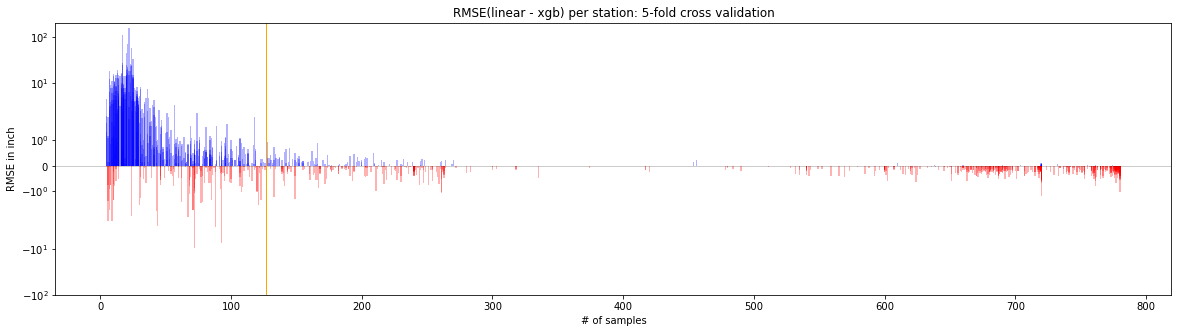

In [4]:
df_result = pd.read_csv(f"{BASE_DIR}/SiteSpecific/result.csv")

rmse_per_station_linear = df_result.groupby(by="skn").apply(lambda group: mean_squared_error(group['data_in'], group['prediction_multi_linear'], squared=False))
rmse_per_station_xgb = df_result.groupby(by="skn").apply(lambda group: mean_squared_error(group['data_in'], group['prediction_single_xgb'], squared=False))
n_data = df_result.groupby(by="skn").size()
df_rmse = pd.DataFrame({"n_data": n_data, "rmse_linear": rmse_per_station_linear, "rmse_xgb": rmse_per_station_xgb})
df_rmse['diff'] = df_rmse['rmse_linear'] - df_rmse['rmse_xgb']

rmse_linear = mean_squared_error(df_result['data_in'], df_result['prediction_multi_linear'], squared=False)
rmse_xgb = mean_squared_error(df_result['data_in'], df_result['prediction_single_xgb'], squared=False)

print("RMSE using site-specific Linear Regression models: {:.3f}".format(rmse_linear))
print("RMSE using a sigle XGBost model: {:.3f}".format(rmse_xgb))

# df_stats = df_combined.groupby('skn').size().reset_index().rename(columns={0:"n_data"}).groupby("n_data").size().reset_index().rename(columns={0: "n_stations"})

fig, ax = plt.subplots(1, figsize=(20,5))
ax.bar(
    x=df_rmse['n_data'],
    height=df_rmse['diff'],
    width=1,
    color=['b' if item >= 0 else 'r' for item in df_rmse['diff']],
    alpha=0.3
)


ax.set_ylim((-100, 200))
ax.axhline(y=0, linestyle='-', linewidth=1, color='k', alpha=0.2)
ax.axvline(127, linewidth=1, color='orange')
ax.set_xlabel('# of samples')
ax.set_ylabel('RMSE in inch')
# ax.axhline(y=100, linewidth=1, linestyle='--')
    
ax.set_title("RMSE(linear - xgb) per station: 5-fold cross validation")
ax.set(yscale='symlog')
# plt.tight_layout()

# ax.scatter(df_stats['n_data'], df_stats['n_stations'], s=1, c='k', marker='x')
print()

## Hyperparameter Tuning

In [24]:
# Split the stations by the number of samples available
columns = deepcopy(LABELS)
columns.extend(["season_wet", "elevation", "lat", "lon"])
for item in columns:
    print(item, end=' ')

# load datasets
df_train = pd.read_csv(f"{BASE_DIR}/train.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_valid = pd.read_csv(f"{BASE_DIR}/valid.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_test = pd.read_csv(f"{BASE_DIR}/test.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_combined = pd.concat([df_train, df_valid, df_test])

air2m air1000_500 hgt500 hgt1000 omega500 pottemp1000-500 pottemp1000-850 pr_wtr shum-uwnd-700 shum-uwnd-925 shum-vwnd-700 shum-vwnd-950 shum700 shum925 skt slp season_wet elevation lat lon 

# skn selsction:
1. Split the entire data into two: everything 2007 (inclusive) and everything after 2007 (exclusive)
2. select the stations which exist both on the test set and the training set, AND which have more than 400 training set.

In [25]:
# prepare held-out test set: any data after 2007 (exclusive)
df_train_original = df_combined[df_combined['year'] <= 2007]
df_test_original = df_combined[df_combined['year'] > 2007]

# get the intersection
intersection = set(df_test_original['skn'].unique()).intersection(set(df_train_original['skn'].unique()))
df_intersection_skn = pd.DataFrame(intersection, columns={"skn"})

df_train_intersection = df_train_original.merge(right=df_intersection_skn, left_on='skn', right_on='skn')
df_test_intersection = df_test_original.merge(right=df_intersection_skn, left_on='skn', right_on='skn')

# prune stations without enough data
threshold = 400
df_train_intersection_skn = df_train_intersection.groupby('skn').size().reset_index().rename(columns={0: "n_samples"})
df_train_intersection_skn_high_samples = df_train_intersection_skn[df_train_intersection_skn["n_samples"] > threshold]
df_train = df_train_intersection.merge(right=df_train_intersection_skn_high_samples, left_on='skn', right_on='skn')
df_test = df_test_intersection.merge(right=df_train_intersection_skn_high_samples, left_on='skn', right_on='skn')

In [26]:
a = set(df_train['skn'].unique())
b = set(df_test['skn'].unique())
assert len(a - b) == 0
assert len(b - a) == 0

In [7]:
# hyperparameter tuning:
# for a specific parameter, get site-specific predictions using cross_val_predict

In [27]:
df_skn_samples = pd.DataFrame(np.random.choice(df_train['skn'].unique(), size=30, replace=False), columns={"skn"})
df_train_samples = df_train.merge(right=df_skn_samples, left_on='skn', right_on='skn')

In [11]:
parameters = [
    sherpa.Choice('n_estimators', list(range(100, 310, 10))),
    sherpa.Choice('early_stopping_rounds', list(range(1, 10))),
    sherpa.Choice('learning_rate', [0.05, 0.1]),
    sherpa.Discrete('max_depth', [1, 5]),
]


alg = sherpa.algorithms.RandomSearch(max_num_trials=10)
study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True)

n_folds = 5
for trial in study:
    # set up the hyperparameters
    start = time.time()
    line = '===============================================\n'
    params = {
        "n_estimators": trial.parameters['n_estimators'],
        "learning_rate": trial.parameters['learning_rate'],
        "max_depth": trial.parameters['max_depth'],
        "early_stopping_rounds": trial.parameters['early_stopping_rounds'],
        "verbosity": 0
    }
    
    print(params)
    line += str(params) + '\n'
    
    # stations with low number of samples
    y_true = []
    y_pred = []
    for name, group in df_train_samples.groupby('skn'):
        line = ''
        group.sort_values(by=["year", "month"], inplace=True)
        
        X = np.array(group[columns])
        Y = np.array(group['data_in'])
        
        kf = KFold(n_splits=5)
#         for temp_index, test_index in kf.split(X):
#             train_index, valid_index = train_test_split(temp_index, test_size=0.2, shuffle=False)
#             Xtrain, Xvalid, Xtest = X[train_index], X[valid_index], X[test_index]
#             Ytrain, Yvalid, Ytest = Y[train_index], Y[valid_index], Y[test_index]
            
#             model = XGBRegressor(**params)
#             model.fit(
#                 Xtrain,
#                 Ytrain,
#                 eval_set=[(Xtrain, Ytrain), (Xvalid, Yvalid)],
#                 early_stopping_rounds=trial.parameters['early_stopping_rounds'],
#                 verbose=False
#             )
            
#             y_true.extend(Ytest)
#             y_pred.extend(model.predict(Xtest))
        for train_index, test_index in kf.split(X):
            Xtrain, Xtest = X[train_index], X[test_index]
            Ytrain, Ytest = Y[train_index], Y[test_index]
            model = XGBRegressor(**params)
            model.fit(
                Xtrain, Ytrain,
                eval_set=[(Xtrain, Ytrain), (Xtest, Ytest)],
                # early_stopping_rounds=trial.parameters['early_stopping_rounds'],
                verbose=False,
                # eval_metric="rmse"
            )
            
            y_true.extend(Ytest)
            y_pred.extend(model.predict(Xtest))
            
        # print('===========')
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"RMSE on test set: {rmse}")
    
    study.add_observation(
        trial=trial,
        iteration=1,
        objective=rmse,
        # context={'rmse_high': rmse_high}
    )

    study.finalize(trial)

# print(study.get_best_result())

INFO:sherpa.core:
-------------------------------------------------------
SHERPA Dashboard running. Access via
http://10.100.11.206:8880 if on a cluster or
http://localhost:8880 if running locally.
-------------------------------------------------------


 * Serving Flask app 'sherpa.app.app' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


{'n_estimators': 250, 'learning_rate': 0.1, 'max_depth': 3, 'early_stopping_rounds': 6, 'verbosity': 0}
RMSE on test set: 4.857173589587817
{'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 4, 'early_stopping_rounds': 6, 'verbosity': 0}


KeyboardInterrupt: 

In [31]:
# params = {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 5, 'early_stopping_rounds': 4, 'verbosity': 0}
params = {'n_estimators': 250, 'learning_rate': 0.1, 'max_depth': 3, 'early_stopping_rounds': 6, 'verbosity': 0}
params = {'n_estimators': 260, 'learning_rate': 0.1, 'max_depth': 3, 'early_stopping_rounds': 8, 'verbosity': 0}
# y_pred = []
# y_true = []
df_xgb = []
df_xgb_train = []

for name, group in df_train.groupby('skn'):
    
    group.sort_values(by=["year", "month"], inplace=True)
    xgboost = XGBRegressor(**params)
    Xtemp = np.array(group[columns])
    Ytemp = np.array(group['data_in'])
    
    Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(Xtemp, Ytemp, test_size=0.2, shuffle=False)
    
    Xtest = np.array(df_test[df_test['skn'] == name][columns])
    Ytest = np.array(df_test[df_test['skn'] == name]['data_in'])
    xgboost.fit(Xtrain, Ytrain, eval_set=[(Xtrain, Ytrain), (Xvalid, Yvalid)], early_stopping_rounds=params['early_stopping_rounds'], verbose=False)
    
    yhat = xgboost.predict(Xtest)
    
    df_xgb.append(pd.DataFrame({"skn": [name] * len(Ytest), "pred": yhat, "data_in": Ytest}))
    df_xgb_train.append(pd.DataFrame({"skn": [name] * len(Ytrain), "pred": xgboost.predict(Xtrain), "data_in": Ytrain}))

In [32]:
df_xgb = pd.concat(df_xgb)

In [33]:
mean_squared_error(df_xgb['data_in'], df_xgb['pred'], squared=False)

3.922172061254523

In [17]:
rmse_per_station = []
for name, group in df_xgb.groupby('skn'):
    rmse_per_station.append(mean_squared_error(group['data_in'], group['pred'], squared=False))

(array([27., 39., 40., 28., 27., 23., 12.,  4.,  7.,  4.,  5.,  3.,  3.,
         1.,  3.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  2.]),
 array([ 0.6917784 ,  1.1606273 ,  1.62947619,  2.09832509,  2.56717398,
         3.03602288,  3.50487177,  3.97372067,  4.44256956,  4.91141846,
         5.38026735,  5.84911625,  6.31796514,  6.78681403,  7.25566293,
         7.72451182,  8.19336072,  8.66220961,  9.13105851,  9.5999074 ,
        10.0687563 , 10.53760519, 11.00645409, 11.47530298, 11.94415188,
        12.41300077, 12.88184967, 13.35069856, 13.81954746, 14.28839635,
        14.75724525]),
 <BarContainer object of 30 artists>)

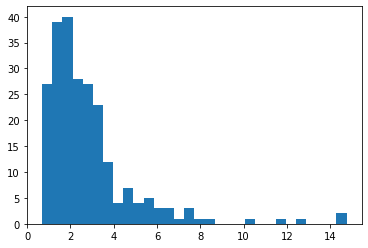

In [18]:
plt.hist(rmse_per_station, bins=30)

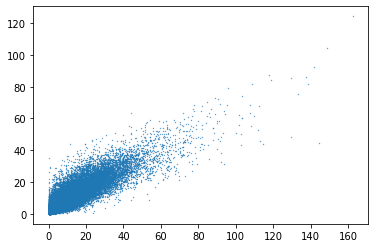

In [20]:
fig, ax = plt.subplots(1)
ax.scatter(df_xgb['data_in'], df_xgb['pred'], s=0.1)

In [21]:
y_pred = []
y_true = []
df_ = []
for name, group in df_train.groupby('skn'):
    linear_regression = LinearRegression()
    group.sort_values(by=["year", "month"], inplace=True)
    Xtrain = np.array(group[columns])
    Ytrain = np.array(group['data_in'])
    
    Xtest = np.array(df_test[df_test['skn'] == name][columns])
    Ytest = np.array(df_test[df_test['skn'] == name]['data_in'])
    
    linear_regression.fit(Xtrain, Ytrain)
    
    yhat = linear_regression.predict(Xtest)
    
    y_pred.extend(yhat)
    y_true.extend(Ytest)
    
    df_.append(pd.DataFrame({"skn": [name] * len(Ytest), "pred": yhat, "data_in": Ytest}))

In [22]:
mean_squared_error(y_true, y_pred, squared=False)

3.7977115828253067

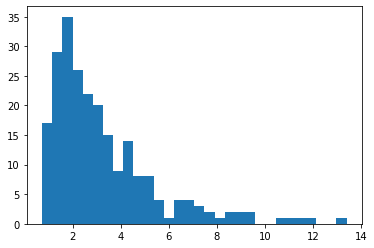

In [23]:
df_result_linear = pd.concat(df_)
rmse_per_station = []
for name, group in df_result_linear.groupby('skn'):
    rmse_per_station.append(mean_squared_error(group['data_in'], group['pred'], squared=False))
plt.hist(rmse_per_station, bins=30)
print()